In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [7]:
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('stopwords')

# def remove_english_stopwords(text):
#    stop_words = set(stopwords.words('english'))
#    word_tokens = word_tokenize(text)
#    filtered_text = [word for word in word_tokens if not word in stop_words]
#    return ' '.join(filtered_text)

# def remove_unnecessary_char(text):
#     text = re.sub('\n',' ',text) # Remove every '\n'
#     text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
#     text = re.sub('  +', ' ', text) # Remove extra spaces
#     return text

# def remove_nonaplhanumeric(text):
#     text = re.sub('[^0-9a-zA-Z]+', ' ', text)
#     return text



In [8]:
# def preprocess(text):
#     text = remove_nonaplhanumeric(text) 
#     text = remove_unnecessary_char(text) 
#     text = remove_english_stopwords(text) 
#     return text

Train data contain text and labels with answers.

In [9]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
# train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
# train_data.head()

We need to found which length of message we will analyse for prediction

In [11]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


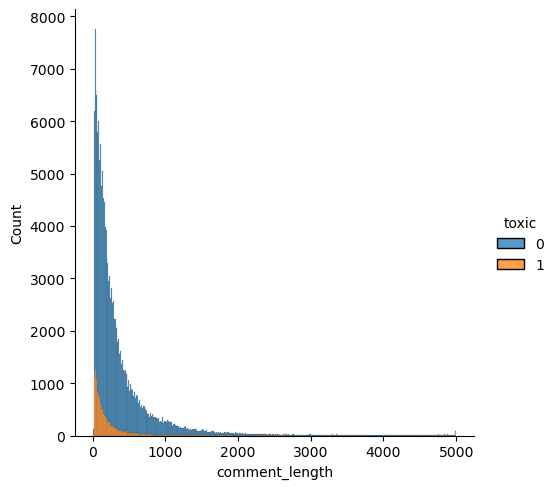

In [12]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [13]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,319
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,57
001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40


Length of toxic comments: max 5000, min 4, mean 209.4926114816268, median 84.0.

In [14]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 8 mean 295.24604420034 median 123.0 75% 271.0


 So 300 symbols should be enough.

In [15]:
max_comment_len = 300

Test data contain two files with text and labels separately.

In [16]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [17]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


And some labels has value of -1, that indicates it was not used for scoring; (Note: file added after competition close!)

In [18]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


Solution from "Toxic Comment Classification Challenge" on base of RNN, that taken [3rd place](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644)

Neural networks this is a series of algorithms that seek to identify relationships in a data without being explicitly programmed. 

Neural networks works with numbers, so we need convert messages to numbers.

TextVectorization - A preprocessing layer which maps text features to integer sequences.

max_tokens - Maximum size of the vocabulary for this layer.

adapt - Computes a vocabulary of string terms from tokens in a dataset.

encoder - this is vocabulary created on base of training messages, this is first layer of network that convert coming messages into list of numbers.

Embeding - turns positive integers (indexes) into dense vectors of fixed size. Dense vectors this is modern kind of representing words as vector, this solution have famose effect: King - Man + Woman = Queen.

SpatialDropout1D - dropout, however, it drops entire 1D feature maps instead of individual elements. Dropout removes some neurons from network, this solution help to avoid overfitting.

LSTM - Long Short-Term Memory layer, this is kind of Recurrent Neural Network. return_sequences - whether to return the last output in the output sequence, or the full sequence.

Dense - densely-connected NN layer. Final layer that contain 6 neurons with result.

In [19]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

model_bidirectional = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    Bidirectional(LSTM(40, return_sequences=True)),
    Bidirectional(LSTM(40)),
    Dense(6, activation='sigmoid'),
])

Training of neural network this is a process which reduce difference between correct result and result of neural network. NN reduce error by [gradient descent](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent). 

Loss function - a mesure for difference between real and prediction values. There are different [loss functions](https://kitchell.github.io/DeepLearningTutorial/7lossfunctionsoptimizers.html): 
binary crossentropy, 
categorical crossentropy, 
mean squared error.

Gradient descent have [different optimizations](https://www.geeksforgeeks.org/optimization-techniques-for-gradient-descent/):
SGD,
Adam,
Momentum, 
AdaGrad.


In [20]:
model_bidirectional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [21]:
model_bidir_save_path = '/kaggle/working/toxic_model_bidir'
checkpoint_callback_lstm = ModelCheckpoint(
    model_bidir_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [22]:
!rm -r /kaggle/working/toxic_model_lstm

rm: cannot remove '/kaggle/working/toxic_model_lstm': No such file or directory


In [23]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [24]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [25]:
x_train[:2]

array(['Grandma Terri Should Burn in Trash \nGrandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40',
       ', 9 May 2009 (UTC)\nIt would be easiest if you were to admit to being a member of the involved Portuguese Lodge, and then there would be no requirement to acknowledge whether you had a previous account (Carlos Botelho did not have a good record) or not and I would then remove the sockpuppet template as irrelevant. WP:COI permits people to edit those articles, such as MSJapan does, but just means you have to be more careful in ensuring that references back your edits and that NPOV is upheld.   20:29'],
      dtype=object)

In [26]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [27]:
history_bidir = model_bidirectional.fit(
    x_train, 
    y_train, 
    validation_data=(x_val,y_val),
    epochs=5, # 15
    batch_size=512,
    callbacks=[checkpoint_callback_lstm],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9074 - auc: 0.8588
Epoch 1: val_accuracy improved from -inf to 0.98991, saving model to /kaggle/working/toxic_model_bidir
250/250 [==============================] - 167s 586ms/step - loss: 0.1381 - accuracy: 0.9074 - auc: 0.8588 - val_loss: 0.0616 - val_accuracy: 0.9899 - val_auc: 0.9703
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9759 - auc: 0.9759
Epoch 2: val_accuracy improved from 0.98991 to 0.99367, saving model to /kaggle/working/toxic_model_bidir
250/250 [==============================] - 128s 514ms/step - loss: 0.0546 - accuracy: 0.9759 - auc: 0.9759 - val_loss: 0.0513 - val_accuracy: 0.9937 - val_auc: 0.9813
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9931 - auc: 0.9806
Epoch 3: val_accuracy improved from 0.99367 to 0.99370, saving model to /kaggle/working/toxic_model_bidir
250/250 [===============

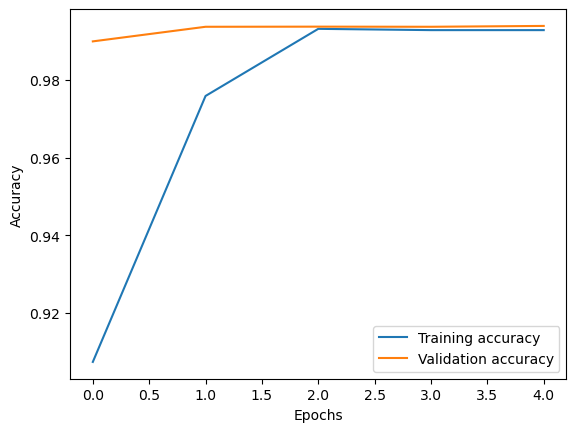

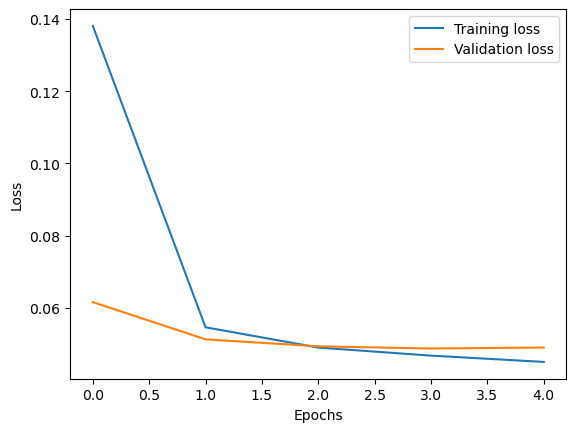

In [28]:
plt.plot(history_bidir.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_bidir.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_bidir.history['loss'], 
         label='Training loss')
plt.plot(history_bidir.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get data for testing

In [29]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

Check result

In [30]:
model_bidirectional.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0797 - accuracy: 0.9943 - auc: 0.9691


[0.07973024994134903, 0.9943261742591858, 0.9691206216812134]

Check result of saved model

In [31]:
saved_model = load_model(model_bidir_save_path)
saved_model.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 55s 25ms/step - loss: 0.0797 - accuracy: 0.9943 - auc: 0.9691


[0.07973024994134903, 0.9943261742591858, 0.9691206216812134]

In [32]:
!zip -r /kaggle/working/toxic_model_bidir.zip /kaggle/working/toxic_model_bidir

  adding: kaggle/working/toxic_model_bidir/ (stored 0%)
  adding: kaggle/working/toxic_model_bidir/keras_metadata.pb (deflated 91%)
  adding: kaggle/working/toxic_model_bidir/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_bidir/variables/variables.index (deflated 65%)
  adding: kaggle/working/toxic_model_bidir/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: kaggle/working/toxic_model_bidir/saved_model.pb (deflated 90%)
  adding: kaggle/working/toxic_model_bidir/assets/ (stored 0%)
  adding: kaggle/working/toxic_model_bidir/fingerprint.pb (stored 0%)


In [33]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [34]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [35]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 5s 5s/step
[0.17, 0.0, 0.02, 0.0, 0.01, 0.0]
[0.99, 0.17, 0.93, 0.05, 0.78, 0.14]
[0.99, 0.48, 0.97, 0.05, 0.89, 0.17]
[0.6, 0.0, 0.1, 0.01, 0.15, 0.03]
[0.98, 0.09, 0.87, 0.04, 0.64, 0.1]


In [36]:
quotes = [
    "It takes a great deal of bravery to stand up to your enemies, but a great deal more to stand up to your friends.",
    "No, no. This kind of mark cannot be seen. It lives in your very skin… Love, Harry. Love.",
    "I would trust Hagrid with my own life.",
    "Also, our caretaker, Mr. Filch, has asked me to remind you that the third-floor corridor on the right-hand side is out of bounds to everyone who does not wish to die a most painful death.",
    "It is not our abilities that show what we truly are. It is our choices.",
]
not_toxic_prediction = saved_model.predict(quotes)
for labels in not_toxic_prediction:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 0s 41ms/step
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.07, 0.0, 0.01, 0.0, 0.01, 0.0]
[0.54, 0.0, 0.1, 0.01, 0.14, 0.03]
[0.01, 0.0, 0.0, 0.0, 0.0, 0.0]


In [37]:
quotes = [
    "Maybe If The Fat Lump Had Given This A Squeeze, He'd Have Remembered To Fall On His Fat Ass.",
    "No One Asked Your Opinion, You Filthy Little Mudblood.",
    "Didn't Mummy Ever Tell You It Was Rude To Eavesdrop, Potter? Oh, Yeah. She Was Dead Before You Could Wipe The Drool Off Your Chin.",
    "You're Gonna Regret This! You And Your Bloody Chicken!",
    "I'm going to kill you, Harry Potter. I'm going to destroy you.",
]
toxic_prediction = saved_model.predict(quotes)
for labels in toxic_prediction:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 0s 39ms/step
[0.96, 0.05, 0.8, 0.03, 0.68, 0.09]
[0.87, 0.01, 0.37, 0.01, 0.36, 0.05]
[0.7, 0.0, 0.15, 0.01, 0.23, 0.05]
[0.98, 0.15, 0.84, 0.05, 0.75, 0.13]
[0.88, 0.01, 0.32, 0.02, 0.42, 0.08]


In [38]:

predicts= saved_model.predict(x_test ,verbose=1)

2000/2000 [==============================] - 48s 24ms/step


In [39]:
for i in predicts[:5]:
     print([ round(lbl, 2) for lbl in i])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.31, 0.0, 0.04, 0.0, 0.05, 0.01]
[0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n")


998/998 [==============================] - 21s 21ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.60      0.90      0.72      3056
           1       0.30      0.83      0.44       321
           2       0.60      0.94      0.73      1715
           3       0.11      0.08      0.09        74
           4       0.51      0.92      0.66      1614
           5       0.16      0.49      0.24       294

   micro avg       0.52      0.89      0.66      7074
   macro avg       0.38      0.69      0.48      7074
weighted avg       0.54      0.89      0.67      7074
 samples avg       0.06      0.09      0.07      7074

F1 Score: 0.6685071638668727
Precision: 0.540368906366567
Recall: 0.8871925360474979

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      3056
           1       0.38      0.68      0.48       321
           2       0.68      0.9

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3056
           1       0.47      0.42      0.45       321
           2       0.77      0.83      0.80      1715
           3       0.00      0.00      0.00        74
           4       0.69      0.73      0.71      1614
           5       0.00      0.00      0.00       294

   micro avg       0.75      0.73      0.74      7074
   macro avg       0.45      0.46      0.46      7074
weighted avg       0.71      0.73      0.72      7074
 samples avg       0.07      0.07      0.07      7074

F1 Score: 0.7220155727147791
Precision: 0.7103701268845001
Recall: 0.734520780322307

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      3056
           1       0.52      0.25      0.33       321
           2       0.81      0.7

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  f1 = f1_score(y_test, y_pred, average='weighted')
  clr = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n")

2000/2000 [==============================] - 48s 24ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.36      0.95      0.53      6090
           1       0.14      0.83      0.24       367
           2       0.35      0.94      0.50      3691
           3       0.05      0.09      0.07       211
           4       0.30      0.92      0.45      3427
           5       0.15      0.48      0.23       712

   micro avg       0.32      0.90      0.47     14498
   macro avg       0.23      0.70      0.34     14498
weighted avg       0.32      0.90      0.48     14498
 samples avg       0.06      0.09      0.07     14498

F1 Score: 0.4750179410884678
Precision: 0.32357010459771923
Recall: 0.9012967305835288

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.41      0.92      0.57      6090
           1       0.20      0.72      0.31       367
           2       0.42      0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.3
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.45      0.90      0.60      6090
           1       0.23      0.60      0.33       367
           2       0.49      0.87      0.62      3691
           3       0.03      0.01      0.01       211
           4       0.44      0.79      0.56      3427
           5       0.16      0.03      0.05       712

   micro avg       0.44      0.80      0.57     14498
   macro avg       0.30      0.53      0.36     14498
weighted avg       0.43      0.80      0.55     14498
 samples avg       0.07      0.08      0.07     14498

F1 Score: 0.5541383828960695
Precision: 0.42954696601517417
Recall: 0.8023175610429024

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.48      0.88      0.62      6090
           1       0.29      0.52      0.37       367
           2       0.56      0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.52      0.85      0.64      6090
           1       0.36      0.32      0.34       367
           2       0.62      0.78      0.69      3691
           3       0.00      0.00      0.00       211
           4       0.59      0.64      0.61      3427
           5       0.00      0.00      0.00       712

   micro avg       0.56      0.71      0.62     14498
   macro avg       0.35      0.43      0.38     14498
weighted avg       0.53      0.71      0.60     14498
 samples avg       0.07      0.07      0.07     14498

F1 Score: 0.5997895296377748
Precision: 0.5250577544152831
Recall: 0.7134087460339357

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.56      0.81      0.66      6090
           1       0.41      0.09      0.15       367
           2       0.68      0.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.61      0.76      0.68      6090
           1       0.00      0.00      0.00       367
           2       0.75      0.66      0.70      3691
           3       0.00      0.00      0.00       211
           4       0.76      0.41      0.53      3427
           5       0.00      0.00      0.00       712

   micro avg       0.67      0.58      0.62     14498
   macro avg       0.35      0.30      0.32     14498
weighted avg       0.63      0.58      0.59     14498
 samples avg       0.07      0.05      0.06     14498

F1 Score: 0.5887462789655122
Precision: 0.626388969184943
Recall: 0.5833908125258657

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      6090
           1       0.00      0.00      0.00       367
           2       0.83      0.5

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1